# Data Visualisation

## Task 1

For the incoming climate data plot the line graph of air temperature against
arrival time. You need to label some interesting points such as maximum
and minimum values.

In [1]:
from time import sleep
from kafka3 import KafkaConsumer
from json import loads

import datetime as dt
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


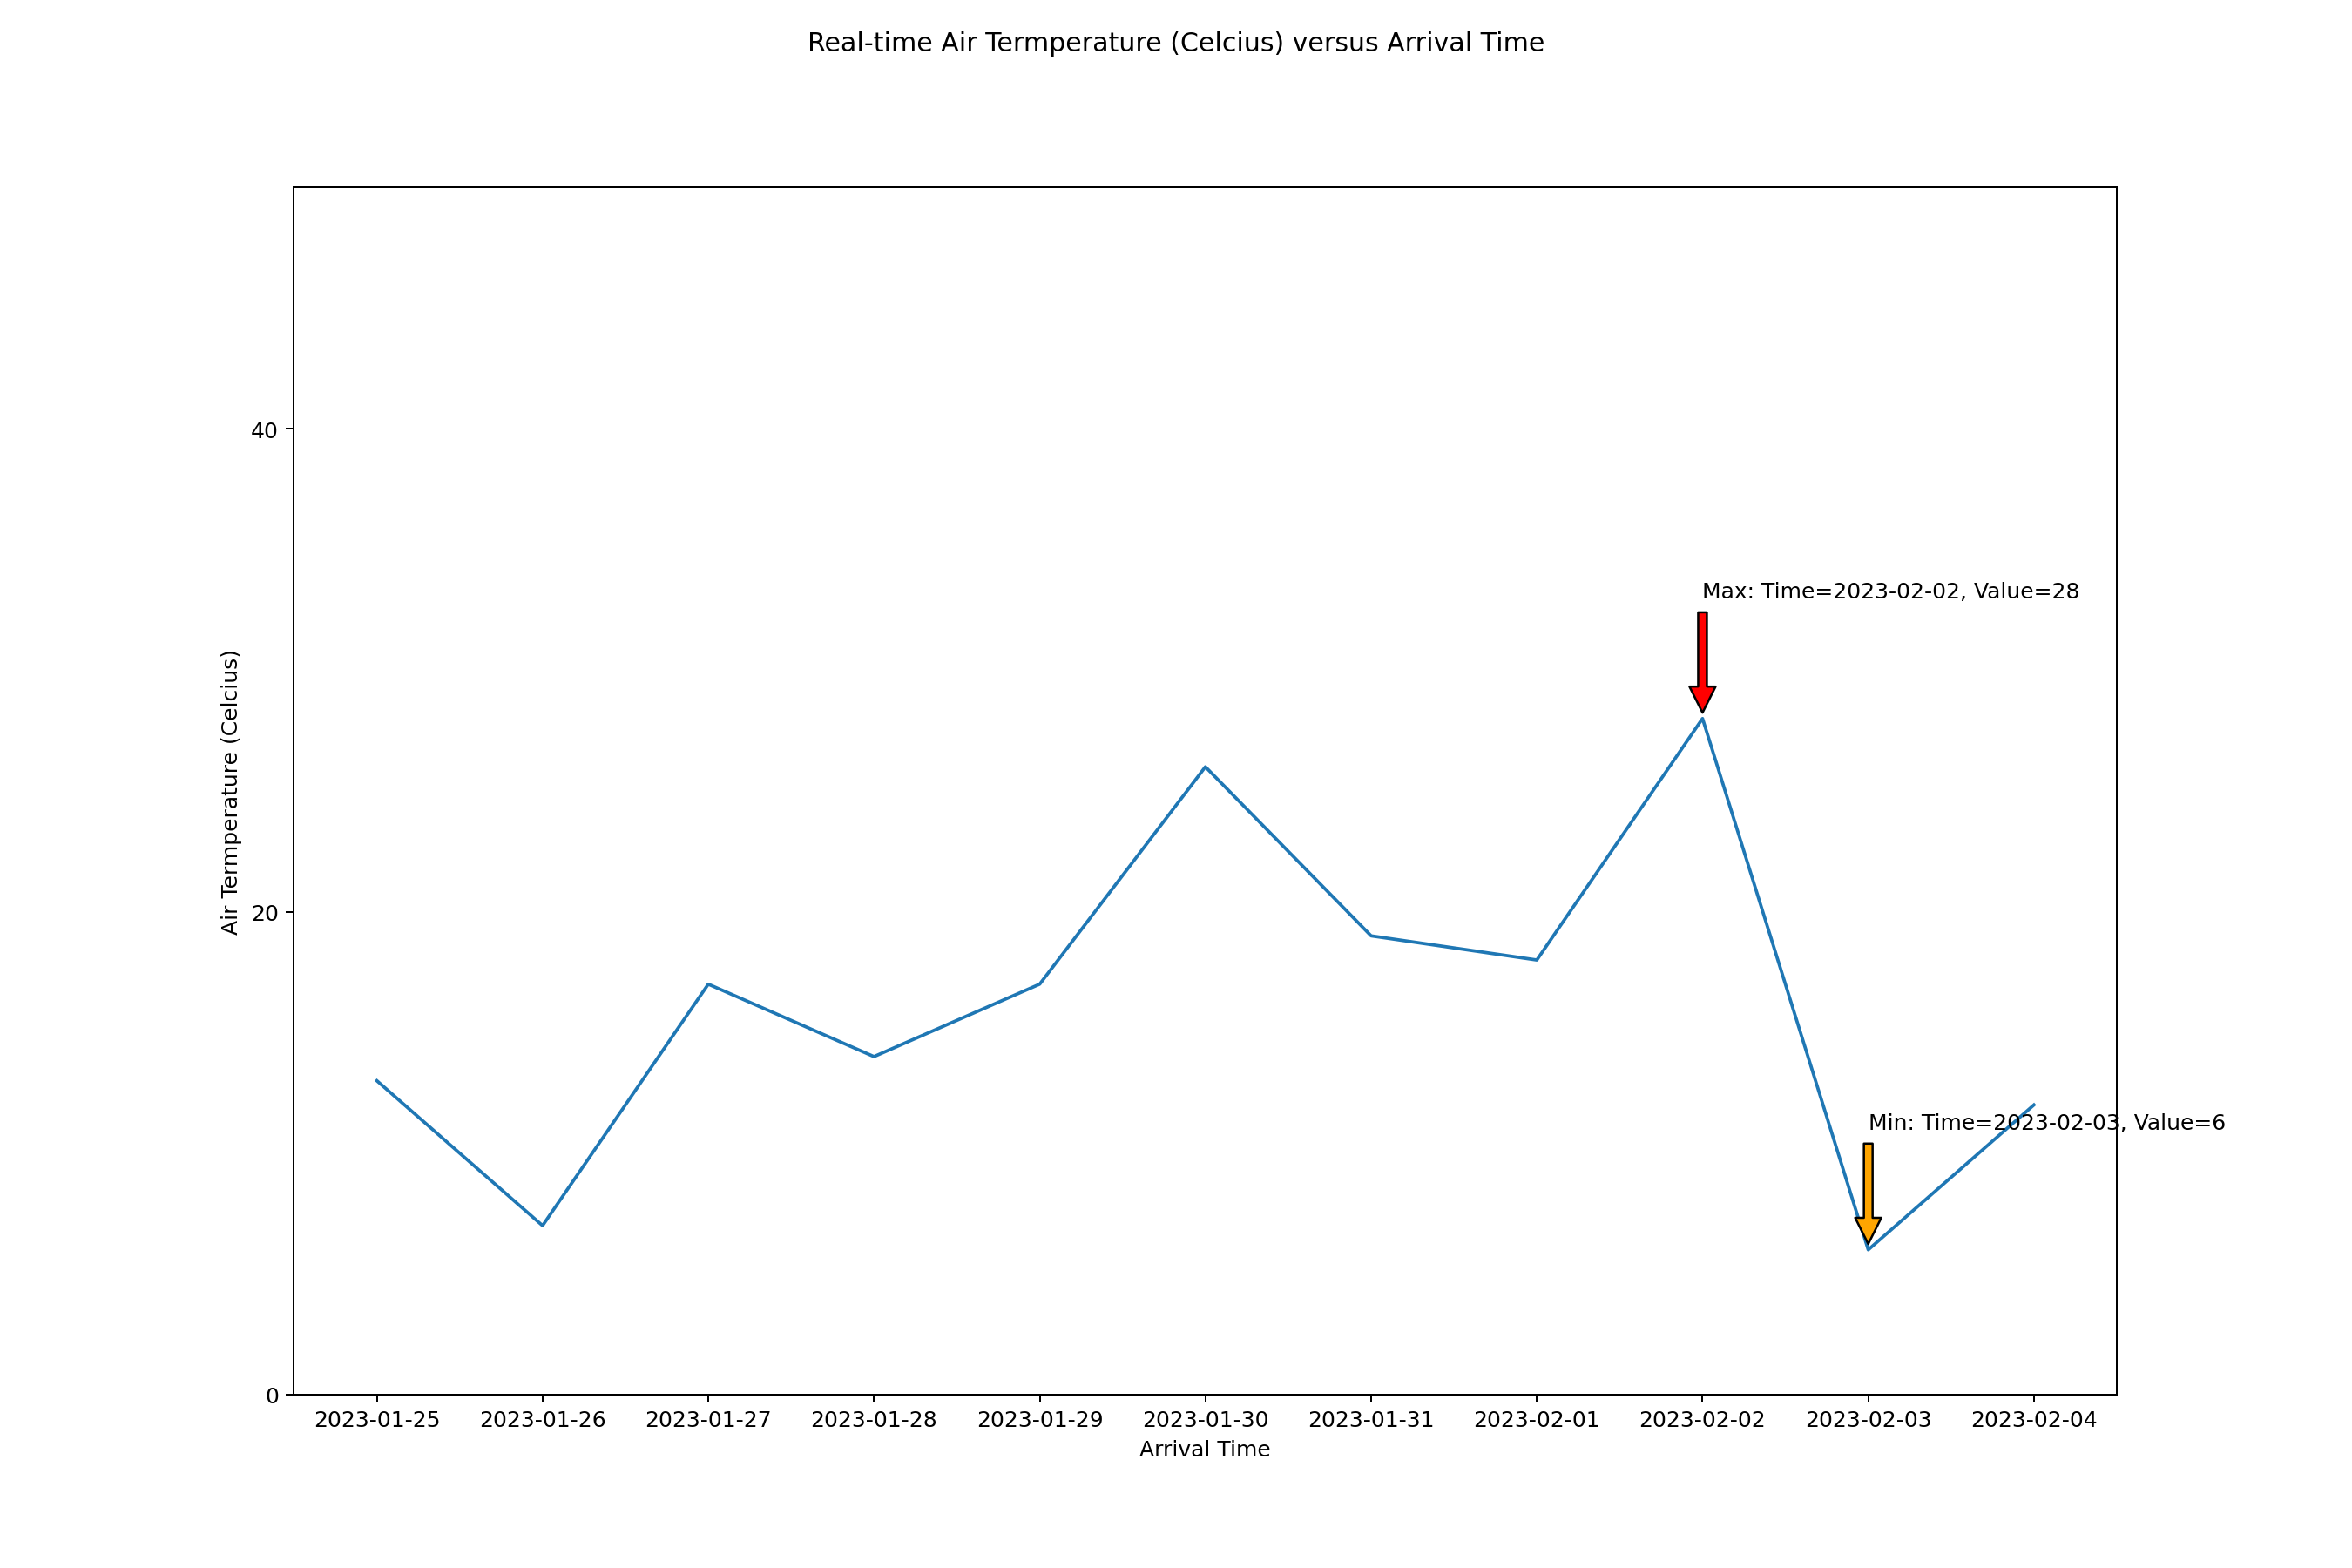

KeyboardInterrupt: 

In [2]:
TOPIC = "climate"
HOST = "localhost"

# display graph inline in notebook
%matplotlib notebook


def annotate_max(x, y, ax=None):
    # get max y coordinates
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]

    text = "Max: Time={}, Value={}".format(xmax, ymax)

    if not ax:
        # is axes does not exist, create one
        ax = plt.gca()
    # create annotation for max coordinates
    ax.annotate(
        text,
        xy=(xmax, ymax),
        xytext=(xmax, ymax + 5),
        arrowprops=dict(facecolor="red", shrink=0.05),
    )


def annotate_min(x, y, ax=None):
    # get min y coordinates
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = "Min: Time={}, Value={}".format(xmin, ymin)
    if not ax:
        # is axes does not exist, create one
        ax = plt.gca()
    # create annotation for max coordinates
    ax.annotate(
        text,
        xy=(xmin, ymin),
        xytext=(xmin, ymin + 5),
        arrowprops=dict(facecolor="orange", shrink=0.05),
    )


def connect_kafka_consumer():
    # create consumer to subscribe to kafka topics
    _consumer = None
    try:
        _consumer = KafkaConsumer(
            TOPIC,
            # consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
            auto_offset_reset="earliest",  # comment this if you don't want to consume earliest available message
            bootstrap_servers=[f"{HOST}:9092"],
            value_deserializer=lambda x: loads(x.decode("ascii")),
            api_version=(0, 10),
        )
    except Exception as ex:
        print("Exception while connecting Kafka")
        print(str(ex))
    finally:
        return _consumer


def init_plots():
    try:
        width = 15
        height = 10
        fig = plt.figure(figsize=(width, height))  # create new figure
        ax = fig.add_subplot(111)  # adding the subplot axes to the given grid position
        # giving figure a title
        fig.suptitle("Real-time Air Temperature (Celcius) versus Arrival Time")
        set_plot_config(ax)
        fig.show()  # displaying the figure
        fig.canvas.draw()  # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))


def set_plot_config(ax):
    # configure plot with basic labels and setup
    ax.set_xlabel("Arrival Time")
    ax.set_ylabel("Air Temperature (Celcius)")
    ax.set_ylim(0, 50)
    ax.set_yticks([0, 20, 40])


def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        for message in consumer:
            data = message.value

            # append to containers for plotting
            date = data["date"]
            temperature = data["air_temperature_celcius"]
            x.append(date)
            y.append(temperature)

            # start plotting only when we have 10 data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
                set_plot_config(ax)
                annotate_max(x, y)
                annotate_min(x, y)
                fig.canvas.draw()
                # removing the item in the first position
                x.pop(0)
                y.pop(0)
    except Exception as ex:
        print(str(ex))


if __name__ == "__main__":
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)

## Task 2

Write python programs using pymongo to get the data from the MongoDB
collection(s) created in Part B, Task 1 and perform the following visualisations.

a. Plot a bar chart to visualise the total number of fire records based on each hour.

<IPython.core.display.Javascript object>


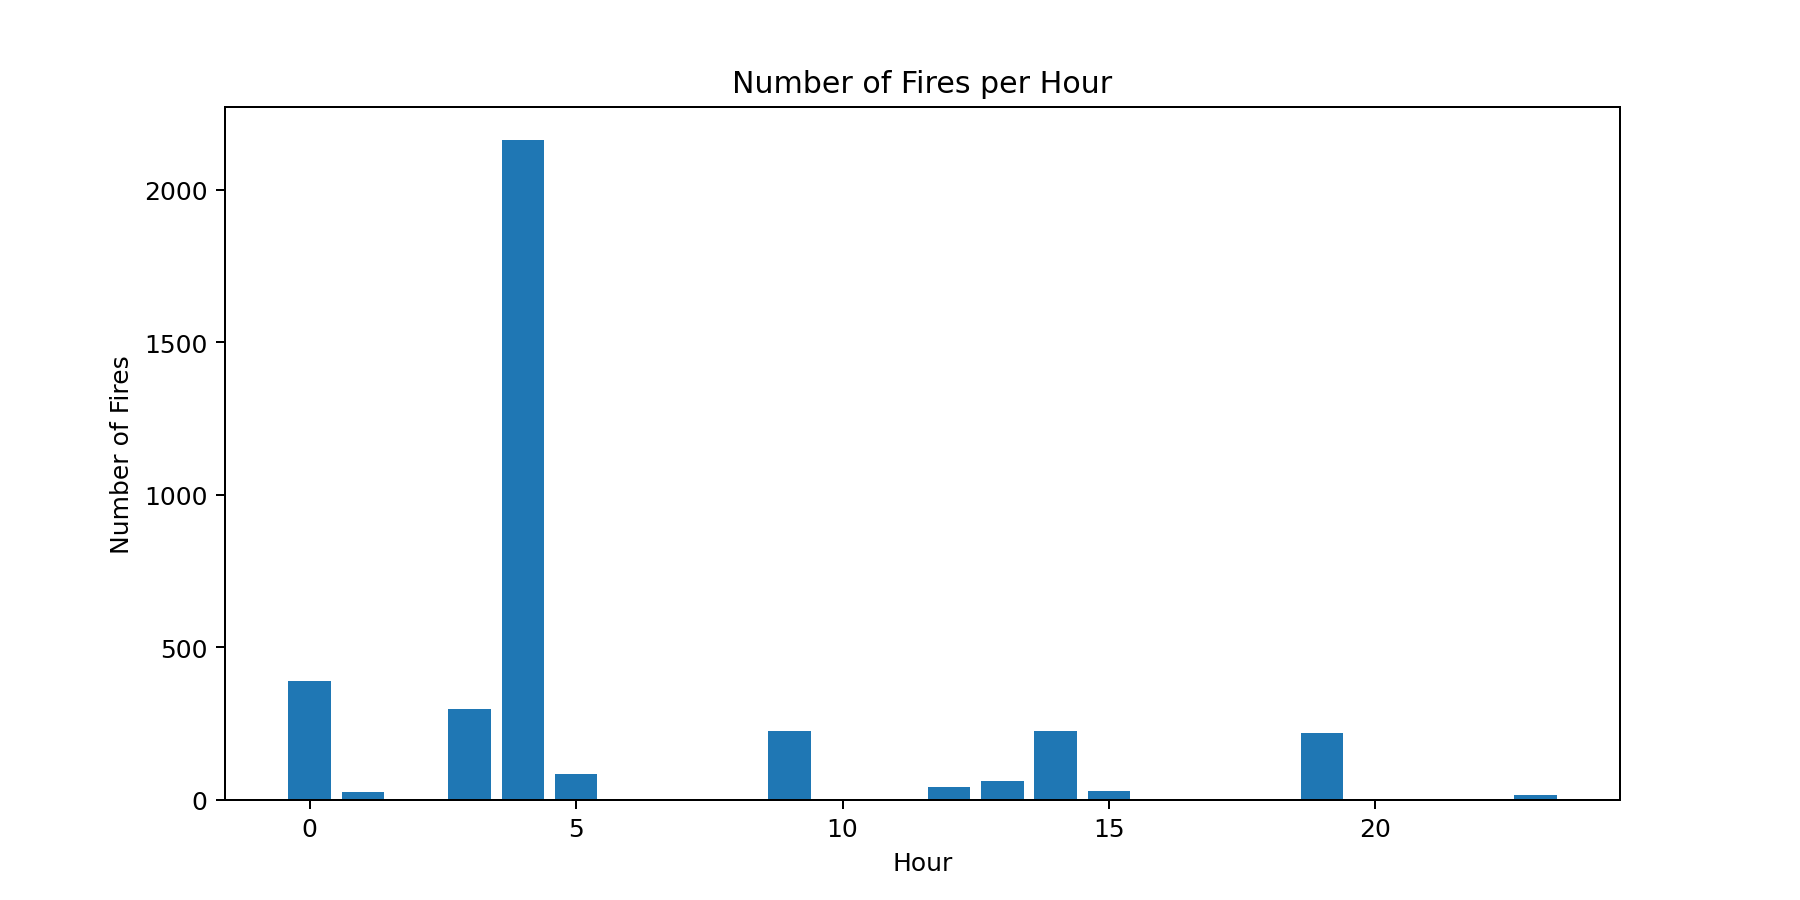

In [3]:
from pymongo import MongoClient
import matplotlib.pyplot as plt

# initialize client and database connection
client = MongoClient()
db = client.fit3182_assignment_db
collection = db.climate_historic


# unwind hotspots so array values is unnested into separate rows
# since timestamp is a string, $dateFromString is used to convert str to date
# $dateFromString expect a proper format datetime string hence a constant data is concat to format it

# "format": "%H" is used in subseqeunt step to extract the hour column
# $convert used to cast the value to an integer for better representation on graph
results = collection.aggregate(
    [
        {"$unwind": "$hotspots"},
        {
            "$addFields": {
                "hour": {
                    "$dateFromString": {
                        "dateString": {
                            "$concat": ["1970-01-01T", "$hotspots.timestamp", "Z"]
                        }
                    }
                }
            }
        },
        {
            "$group": {
                "_id": {
                    "$convert": {
                        "input": {"$dateToString": {"format": "%H", "date": "$hour"}},
                        "to": "int",
                    }
                },
                "number_of_fires": {"$sum": 1},
            }
        },
        {"$project": {"_id": 0, "hour": "$_id", "number_of_fires": 1}},
    ]
)

data = list(results)
hours = [x["hour"] for x in data]
fires = [x["number_of_fires"] for x in data]

# plot graph
plt.figure(figsize=(10, 5))
plt.bar(hours, fires)
plt.xlabel("Hour")
plt.ylabel("Number of Fires")
plt.title("Number of Fires per Hour")
plt.show()

b. In a map visualise fire locations as markers. Use a ‘blue’ marker if the cause of the fire was ‘natural’. Otherwise, use a ‘red’ marker. Display detailed information such as air temperature, surface temperature, relative humidity, and confidence with the marker tooltip. See the example below. You can use Folium for map visualisation.

In [4]:
import folium
from pymongo import MongoClient

# initial location Melbourne
fmap = folium.Map(location=[-38.043995, 145.264296], zoom_start=6)

# initialize connection to database
client = MongoClient()
db = client.fit3182_assignment_db
collection = db.climate_historic

# unwind hotspots and match only rows where cause is defined (as not every hotspot is a fire event)
results = collection.aggregate(
    [
        {"$unwind": "$hotspots"},
        {"$match": {"hotspots.cause": {"$exists": True}}},
        {
            "$project": {
                "_id": 0,
                "hotspots": 1,
                "air_temperature_celcius": 1,
                "relative_humidity": 1,
            }
        },
    ]
)

for row in results:
    # extract relevant data from nested object
    cause = row["hotspots"]["cause"]
    longitude = row["hotspots"]["longitude"]
    latitude = row["hotspots"]["latitude"]
    confidence = row["hotspots"]["confidence"]
    surface_temperature = row["hotspots"]["surface_temperature_celcius"]
    air_temperature = row["air_temperature_celcius"]
    relative_humidity = row["relative_humidity"]

    # create tooltop
    tooltip_text = (
        f"<strong>Cause</strong>: {cause}<br>"
        f"<strong>Longitude</strong>: {longitude}<br>"
        f"<strong>Latitude</strong>: {latitude}<br>"
        f"<strong>Confidence</strong>: {confidence}<br>"
        f"<strong>Surface Temperature</strong>: {surface_temperature}<br>"
        f"<strong>Air Temperature</strong>: {air_temperature}<br>"
        f"<strong>Relative Humidity</strong>: {relative_humidity}<br>"
    )

    # mark position on map
    iconColor = "blue" if cause == "natural" else "red"
    folium.Marker(
        location=[latitude, longitude],
        tooltip=tooltip_text,
        icon=folium.Icon(color=iconColor, icon="map-pin"),
    ).add_to(fmap)

fmap